# GenMol - Basics

GenMol is a masked diffusion model trained on molecular SAFE representations for fragment-based molecule generation.  GenMol a generalist model for various drug discovery tasks, including de novo generation, linker design, motif extension, scaffold decoration/morphing, hit generation, and lead optimization.

In this notebook, we discuss conversion between SMILES and SAFE molecular representations, and demonstrate *de novo* generation, fragment completion for motif extension and scaffold decoration, and superstructure generation.  We also assess the generated molecules for validity and uniqueness.

## Setup
Refer to [README.md](README.md) to deploy the GenMol NIM. Here we assume the NIM is running locally.  Update the IP or URL used in the GenMol_Generator for your NIM deployment.

First, we need to import a few dependencies and configure our GenMol interface to point to the NIM `/generate`
interface.

In [1]:
from genmol import GenMol_Generator
from utils import Utils

from rdkit import Chem
from rdkit.Chem import Draw

# SAFE <> SMILES conversion
import safe as sf
import datamol as dm

gm = GenMol_Generator(invoke_url = 'http://127.0.0.1:8000/generate')

## Introduction to GenMol and the use of SAFE, SMILES, and masks.

GenMol is a masked diffusion model trained on molecular Sequential Attachmentbased Fragment Embeddings, or [SAFE representations](https://arxiv.org/abs/2310.10773) for fragment-based molecule generation.  The GenMol NIM accepts both SMILES and SAFE molecular representations as input, but the use of SAFE representations allow explicit specification of fragments, attachment points, and regions of molecule to be masked.  It is important to note that SAFE representations are order invariant, so that the structure of explicitly specified fragments and masked, generated fragments are determined based on attachment points regardless of the order in which the fragments and mask are specified.

The SAFE representation is composed of molecule fragments separated by a `.` token.  These fragments can be coupled with a mask of the form `[*{min_tokens-mask_tokens}]`.  A pure mask can be input without any additional fragments for de novo molecule generation as shown below.  For example, a pure mask of `[*{20-30}]` will return molecules generated with a minimum of 20 and maximum of 30 tokens.  Additional examples are provided that demonstrate the combination of molecule fragments and mask for motif extension and scaffold decoration.

Before diving into the examples, it is useful to see how to translate between SMILES and SAFE representations.  The next few cells demonstrate how to convert between SMILES and SAFE and visualize the results using the [`datamol/safe`](https://github.com/datamol-io/safe) package.  Additional examples can be found in the [SAFE docs](https://safe-docs.datamol.io/stable/).

First, display an example molecule using its SMILES representation.

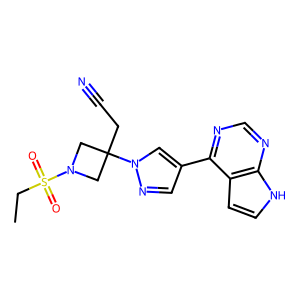

In [2]:
testsmiles = "CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1"
testmol = dm.to_mol(testsmiles)
display(dm.to_image(testmol))

Then use the SAFE encoder to generate the SAFE fragment-based representation.

In [3]:
safe_str = sf.encode(testmol)
print(f"SMILES: {testsmiles}")
print(f"SAFE:   {safe_str}\n represented using {len(safe_str.split('.'))} fragments")

SMILES: CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1
SAFE:   c18ncnc2[nH]ccc12.N15CC67C1.n17cc8cn1.CCS5(=O)=O.C6C#N
 represented using 5 fragments


Then use the `datamol` `to_mol()` function to reconstruct the molecule from the SAFE string.

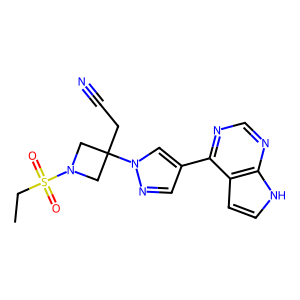

In [4]:
testreconstructed = dm.to_mol(safe_str)
display(dm.to_image(testreconstructed))

We can also visualize the molecule, highlighting the individual fragments that compose it.

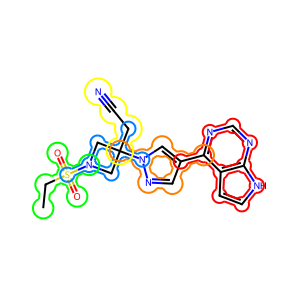

In [5]:
sf.to_image(safe_str)

The examples above demonstrate how to manually use the `datamol/safe` package to convert between SMILES and SAFE representations.  In the examples that follow, we will use the provided `Utils` package that provides utilities for converting and managing fragments and attachment points.

## De novo Generation

In [6]:
molecules = gm.inference(smiles = '[*{15-25}]', num_molecules = 20)[:12]

In [7]:
ms = [Chem.MolFromSmiles(_['smiles']) for _ in molecules]

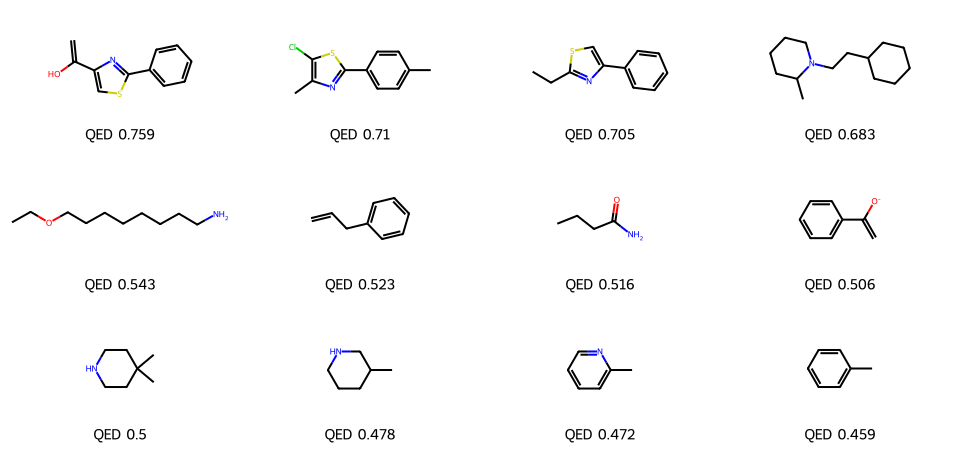

In [8]:
Draw.MolsToGridImage(ms, molsPerRow=4, subImgSize=(240, 150), legends=['QED ' + str(_['score']) for _ in molecules])

## Fragment Completion

### Motif-Extension or Scaffold-Decoration

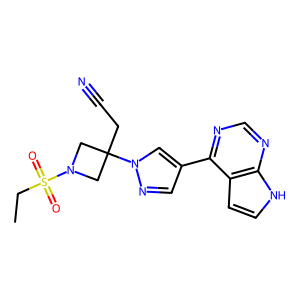

In [9]:
smiles_full = 'CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1'
Draw.MolToImage(Chem.MolFromSmiles(smiles_full))

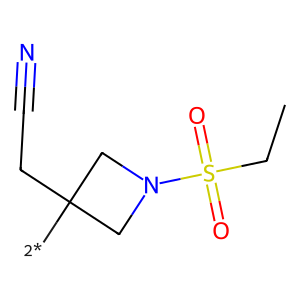

In [10]:
smiles = '[2*]C1(CC#N)CN(S(=O)(=O)CC)C1'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [11]:
safe = Utils.smiles2safe(smiles)
safe

'C124CN3C1.S3(=O)(=O)CC.C4C#N'

In [12]:
molecules = gm.inference(smiles = safe + '.[*{15-25}]', num_molecules = 100, temperature = 2.0, noise = 1.0)[:12]
len(molecules)

12

In [13]:
ms = [Chem.MolFromSmiles(_['smiles']) for _ in molecules]

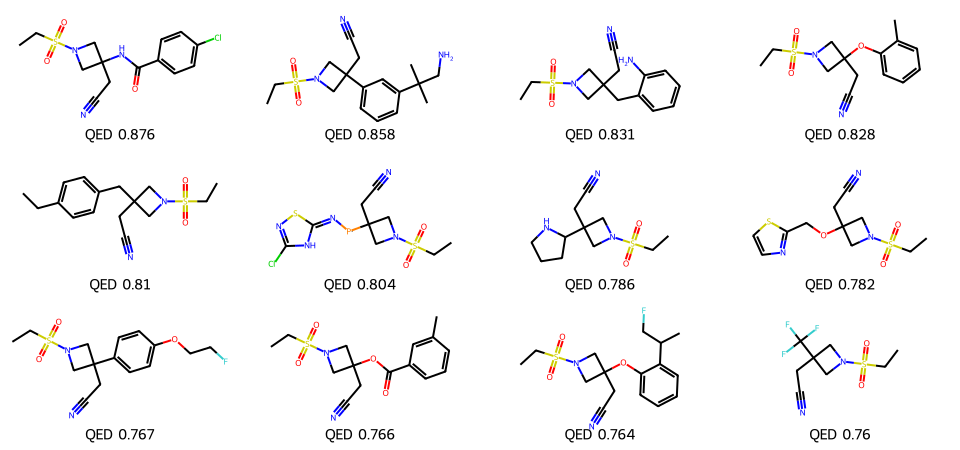

In [14]:
Draw.MolsToGridImage(ms, molsPerRow=4, subImgSize=(240, 150), legends=['QED ' + str(_['score']) for _ in molecules])

## Superstructure Generation

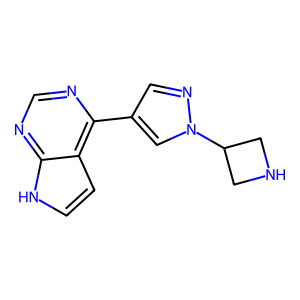

In [15]:
smiles = 'c1nc(-c2cnn(C3CNC3)c2)c2cc[nH]c2n1'
Draw.MolToImage(Chem.MolFromSmiles(smiles))

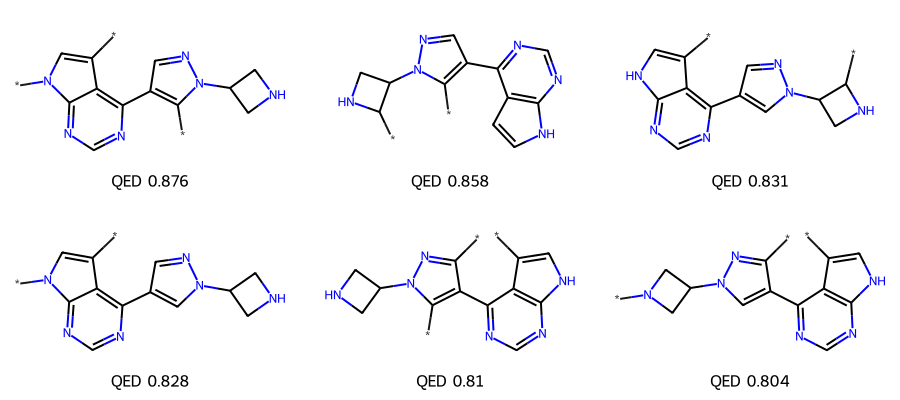

In [16]:
cores = Utils.attachable_points(smiles)[:6]
ms = [Chem.MolFromSmiles(_) for _ in cores]
Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(300, 200), legends=['QED ' + str(_['score']) for _ in molecules])

In [17]:
safes = [Utils.smiles2safe(_) for _ in cores]
molecules = [gm.inference(smiles = _ + '.[*{15-15}]', num_molecules = 10, temperature = 1.5, noise = 1.0)[0] for _ in safes]

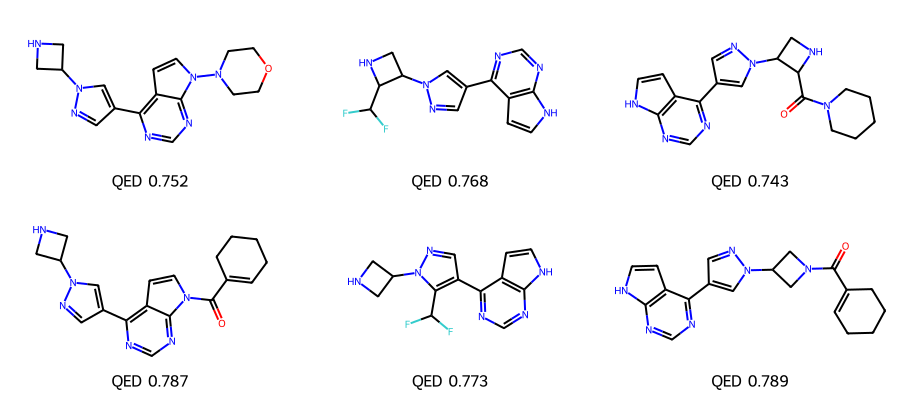

In [18]:
smiless = [_['smiles'] for _ in molecules]
ms = [Chem.MolFromSmiles(_) for _ in smiless]
Draw.MolsToGridImage(ms, molsPerRow=3, subImgSize=(300, 200), legends=['QED ' + str(_['score']) for _ in molecules])

## Benchmarks for Validity and Uniqueness

In [19]:
smiles = '[11*]C1(CC#N)CN(S(=O)(=O)CC)C1'
safe = Utils.smiles2safe(smiles)
safe

'C124CN3C1.S3(=O)(=O)CC.C4C#N'

In [20]:
nsample = 100
ntest = 50

def test():
    molecules = gm.inference(smiles = safe + '.[*{17-17}]', num_molecules = nsample, temperature = 1.2, noise = 1.6, unique = False)
    return len(molecules)/nsample, len(set([_['smiles'] for _ in molecules]))/nsample

data = [test() for _ in range(ntest)]

In [21]:
import pandas as pd
pd.DataFrame(data, columns = ['validity', 'uniqueness']).describe(percentiles=[])

,validity,uniqueness
count,50.000000,50.00000
mean,0.993800,0.78520
std,0.008053,0.04067
min,0.960000,0.70000
50%,0.995000,0.79000
max,1.000000,0.89000


array([[<Axes: title={'center': 'validity'}>,
        <Axes: title={'center': 'uniqueness'}>]], dtype=object)

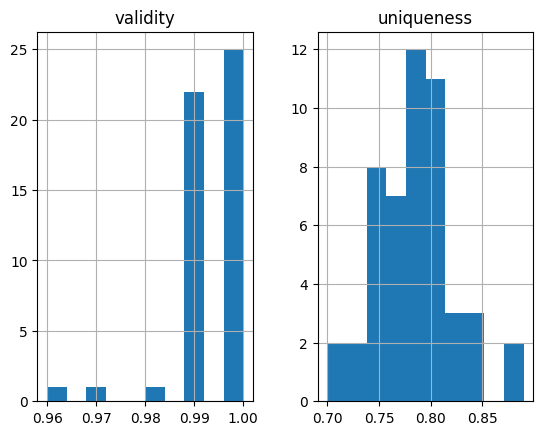

In [22]:
import matplotlib.pyplot as plt
pd.DataFrame(data, columns = ['validity', 'uniqueness']).hist(bins=10)